In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Load Data

In [122]:
df = pd.read_parquet('trials.parquet')
df.head()

,trial,contrast_left,contrast_right,stim_onset,gocue_time,response_type,response_time,feedback_time,feedback_type,reaction_time,reaction_type,mouse,session_date,session_id
0,1,100,0,0.5,1.027216,1.0,1.150204,1.186819,1.0,170.0,1.0,Cori,2016-12-14,5dd41e
1,2,0,50,0.5,0.874414,-1.0,1.399503,1.437623,1.0,230.0,-1.0,Cori,2016-12-14,5dd41e
2,3,100,50,0.5,0.825213,1.0,0.949291,0.986016,1.0,200.0,1.0,Cori,2016-12-14,5dd41e
3,4,0,0,0.5,0.761612,0.0,2.266802,2.296436,1.0,860.0,1.0,Cori,2016-12-14,5dd41e
4,5,50,100,0.5,0.662010,1.0,0.816776,0.827613,-1.0,140.0,1.0,Cori,2016-12-14,5dd41e


## Performance Analysis

How did the mice perform in the task, overall?  Let's use seaborn to make a basic statistical analysis comparing different variables against each other.

Let's examine whether the mice able to reasonably perform the task. On average, how did the subjects respond when presented with various contrast levels on the right and left stimuli?

Make a point plot (points with error bars, connected by a line to indicate continuity) with experiment variables in the following way:
  - **x-axis**: Contrast levels for the left stimulus.
  - **y-axis**: Average response type (-1, 0, or 1)
  - **lines of different hues**: Contrast levels for the right stimulus.

What do you see in this plot; what indication is there that the mice learned the task?

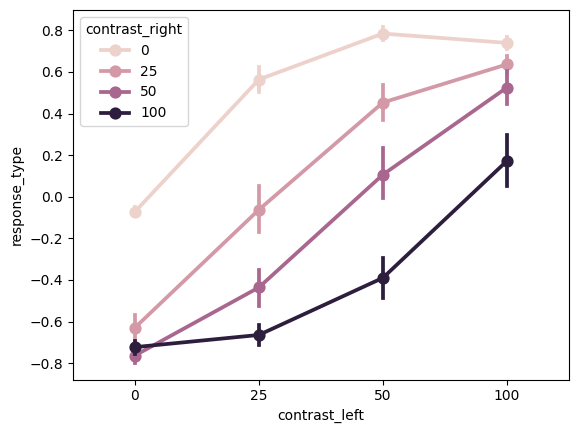

In [123]:
sns.pointplot(data=df, x='contrast_left', hue='contrast_right', y='response_type');

**Making a Simpler Model.**:  The mice had to make a decision of whether to move the wheel left or right based on the *difference* in contrast between the left and right stimulus.  Let's make a new column called `contrast_diff` that contains the contrast difference between the left and right stimuli, and make a point plot that shows the average response type for each value in contrast_diff:
  
  - x-axis: contrast_diff
  - y-axis: response_type
  - trials: only those where the mouse made a wheel turn response (`response_type` is -1 or 1, not 0).

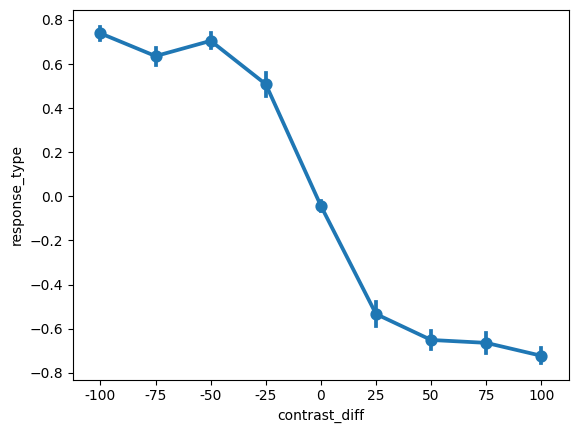

In [124]:
df['contrast_diff'] = df['contrast_right'] - df['contrast_left']
sns.pointplot(data=df, x='contrast_diff', y='response_type');

**Filtering Data by making a Mask**. 

This plot seems to have a clear pattern, but it has a key weakness to it; it is an quantitative average of "categorical values"; values that have no implicit value.  In this case, the `response_type` variable can be -1, 0, or 1; averaging them doesn't give a clear idea of how many 0s there are in the data.  With categorical data that you'd like to treat as continuous, a simple thing that can be done is to reduce the number of categories to 2.  

So, let's simplify the analysis by considering only the trials where the mouse turned the wheel left (response_type == -1) or right (response_type == 1).  That way, if the average response_type is 0, then we know that it means there was an equal number of -1 and 1 values.

```python
mask = df['column'] == 'some_value'
df_masked = df[mask]
```

Let's re-make the psychometric curve point plot (x=`contrast_diff`, y=`respones_type`), but only using the trials where there was an observable response (`response_type != 0`)

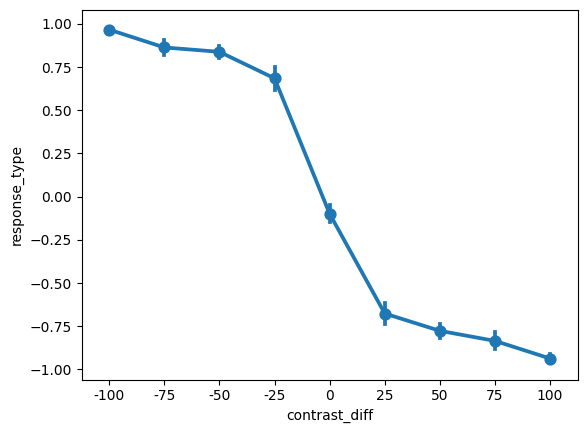

In [119]:
mask = df['response_type'] != 0
sns.pointplot(data=df[mask], x='contrast_diff', y='response_type');

**Response Time Measurement**.  Steinmetz also measured how long it took the mouse to turn the wheel to a certain position (its `response_time`).  Make a point plot: Is there a relationship between the difference in contrasts and the response time?  Only include the trials where the mouse made a wheel turn response.  

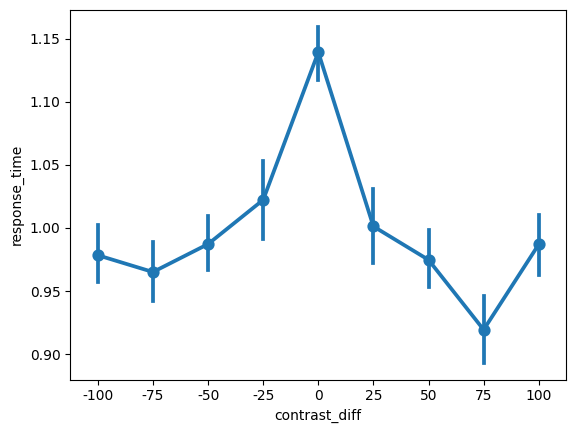

In [120]:
sns.pointplot(data=df[mask], x='contrast_diff', y='response_time');

What is happening where `contrast_diff` is 75? were the mice somehow more responsive at that contrast difference?  

This is an artifact of the experimental design; `response_time` variable shows the trial time in which mouse's response was registered, but it is a complex value; for one thing, it includes both the time it took the mouse to make a decision, as well as the time it took to respond to the random appearance of a "go" cue. At `contrast_diff == 75`, it just happened that the `gocue_time` came much earlier than normal 

Let's verify this by plotting the `contrast_diff` against `gocue_time`.  Notice how the main outlier in the data also occurs at contrast_diff == 75 , as well as at -100.  That's not good; it has nothing to do with the mouse's behavior, and everything to do with the random number generator in the experiment!

Point Plot:
  - x-axis: Contrast difference
  - y-axis: Go-Cue Time
  - trials: where the mouse responded with a wheel turn.

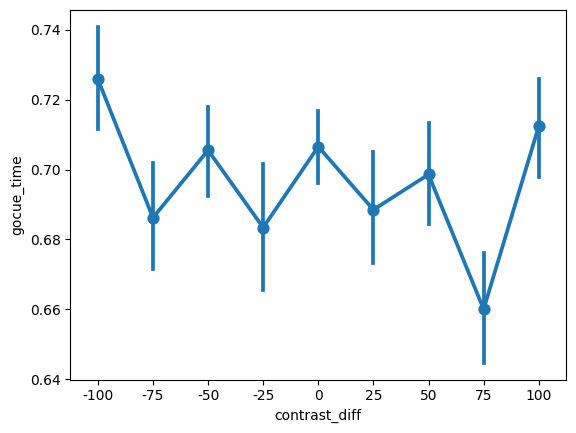

In [125]:
sns.pointplot(data=df[mask], x='contrast_diff', y='gocue_time');



Let's subtract out this effect by calculating a new `response_time_corrected` column, which subtracts the `gocue_time` from the `response_time`. Then, make a point plot showing `contrast_diff` against `response_time_corrected` and see if the pattern in data is simpler.

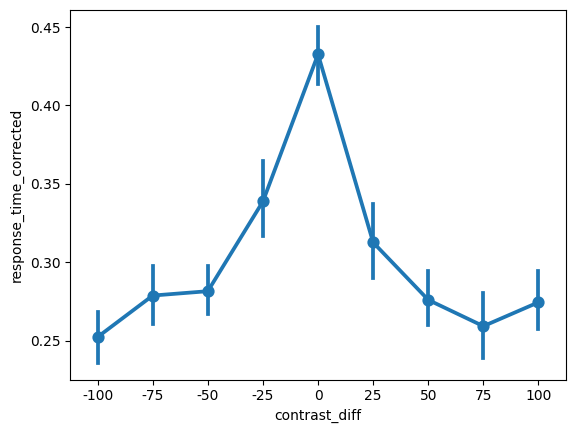

In [133]:
df['response_time_corrected'] = df['response_time'] - df['gocue_time']
sns.pointplot(data=df[mask], x='contrast_diff', y='response_time_corrected');

Better, right?  Let's take one more step in this analysis to simplify the pattern shown.  Instead of calculating the `contrast_diff`, let's calculate the `contrast_diff_absolute`, where the absolute value of the contrast difference is used, so it is always positive.  This more-closely shows the decision that the mice had to make, and allows us to use twice as many values for each point estimation:

  - x-axis: `contrast_diff_absolute`
  - y-axis: `response_time_corrected`
  - mask: only the trials where there was a wheel turn response

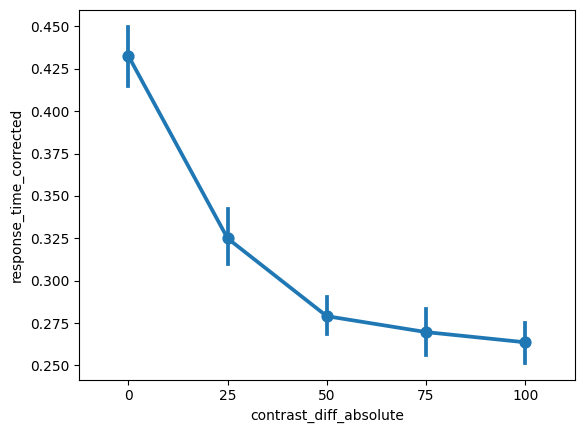

In [135]:
df['contrast_diff_absolute'] = df['contrast_diff'].abs()
sns.pointplot(data=df[mask], x='contrast_diff_absolute', y='response_time_corrected');

Looks great!  We can clearly see how the mice's uncertainty decreased on average, as the contrast difference between the stimuli increased. Let's take one last step to check our results for reliability, though, which can help us see how well this pattern holds up.

Is there a correlation between `contrast_diff_absolute` and `response_time_corrected` for each of the response types (-1 and 1)?   If not, it could indicate something more complex happening in the experiment.
  - x-axis: `contrast_diff_absolute`
  - y-axis: `response_time_correctd`
  - hue: `response_type`:
  - mask: trials where the mouse responded with a wheel turn


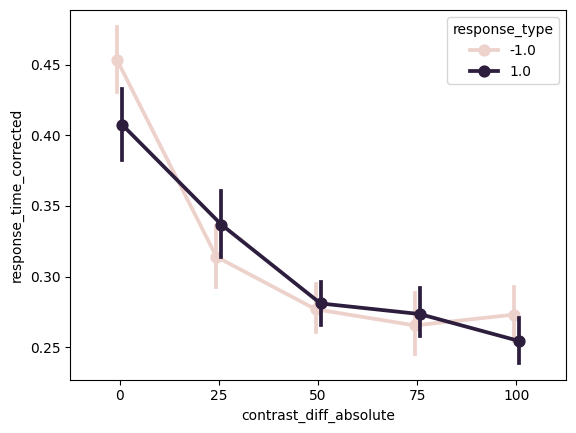

In [137]:
df['contrast_diff_absolute'] = df['contrast_diff'].abs()
sns.pointplot(data=df[mask], x='contrast_diff_absolute', y='response_time_corrected', hue='response_type', dodge=True);

Looks good!  Let's do one last thing to help more-accurately represent the results; address the problem of having a different number of trials in each session.  It could be that only some of the sessions are giving us our results!  This is common in "nested design" experiments, which most neuroscience experiments fit into.  To tell Seaborn to calculate its error bars taking into account each session's data, set `units="session_id`.  


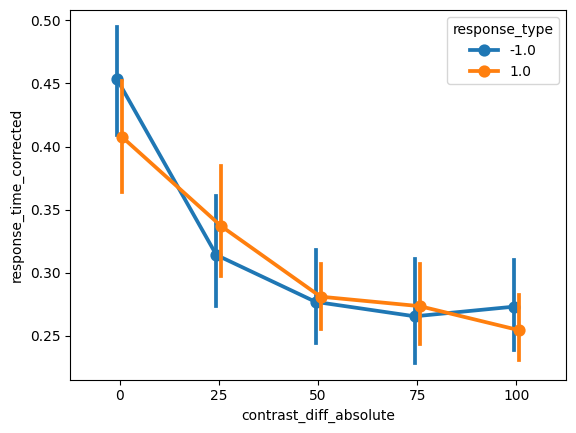

In [138]:
df['contrast_diff_absolute'] = df['contrast_diff'].abs()
sns.pointplot(
    data=df[mask].astype({'response_type': 'category'}), 
    x='contrast_diff_absolute', y='response_time_corrected', hue='response_type', 
    units='session_id', 
    dodge=True,
);

## Wrapping it Up: Exporting a Figure

Let's export our two main results into a single figure with two subplots, then save it as a file (say, for a poster presentation)

In [130]:
plt.style.available;   # remove the semicolon to see other available styles

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


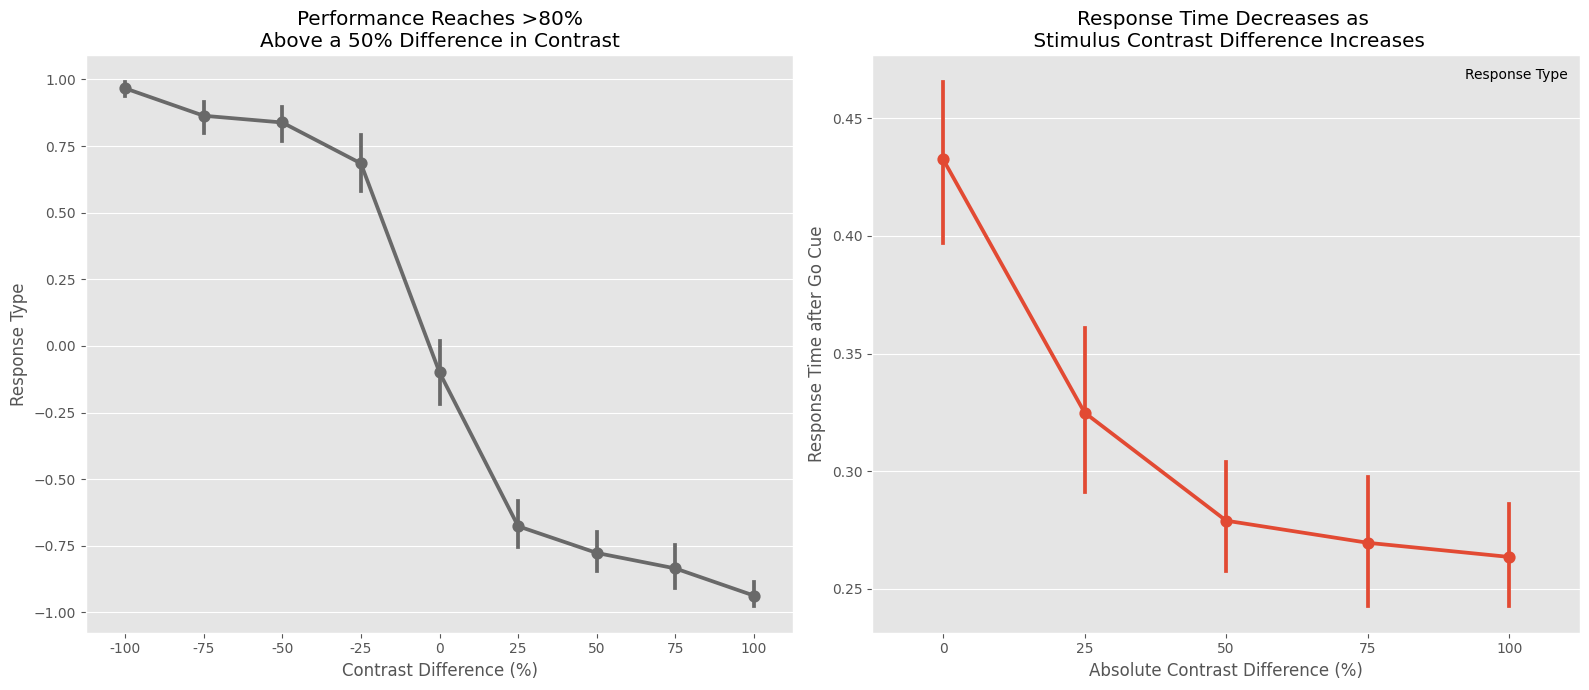

In [139]:
# Figure 1b
with plt.style.context(style='ggplot', after_reset=True):

    plt.figure(figsize=(16, 7))  # changing the figure size is an quick-and-dirty way to change the font size

    # Subplot 1
    plt.subplot(1, 2, 1)

    df['contrast_diff'] = df['contrast_right'] - df['contrast_left']
    mask = df['response_type'] != 0
    sns.pointplot(data=df[mask], x='contrast_diff', y='response_type', color='dimgrey', units='session_id');
    plt.title('Performance Reaches >80%\nAbove a 50% Difference in Contrast')
    plt.xlabel('Contrast Difference (%)')
    plt.ylabel("Response Type")

    # Subplot 2
    plt.subplot(1, 2, 2)

    mask = df['response_type'] != 0
    df['contrast_diff_absolute'] = df['contrast_diff'].abs()
    sns.pointplot(
        data=df[mask].astype({'response_type': 'category'}), 
        x='contrast_diff_absolute', y='response_time_corrected',
        #   hue='response_type', 
        units='session_id', 
        dodge=True,
    );
    plt.title('Response Time Decreases as \n Stimulus Contrast Difference Increases', )
    plt.xlabel('Absolute Contrast Difference (%)')
    plt.ylabel("Response Time after Go Cue")
    plt.legend(title="Response Type", frameon=False);

    # Correct the spacing between subplots, to fix some kinds of accidental overlap.
    plt.tight_layout()

    # Save the figure 
    # plt.savefig('performance.svg', dpi=200)  # for editing later in a vector graphics editor (i.e. Inkscape, Adobe Illustrator)
    plt.savefig('performance.png', dpi=200)  
